In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Quick fits for TESS light curves

In this tutorial, we will fit the TESS light curve for a known transiting planet.
While the :ref:`tess` tutorial goes through the full details of an end-to-end fit, this tutorial is significantly faster to run and it can give pretty excellent results depending on your goals.
Some of the main differences are:

1. We start from the light curve rather than doing the photometry ourselves. This should pretty much always be fine unless you have a very bright, faint, or crowded target.
2. We assume a circluar orbit, but as you'll see later, we can approximately relax this assumption later.
3. We only fit the data near transit. In many cases this will be just fine, but if you have predictable stellar variability (like coherent rotation) then you might do better fitting more data.

We'll fit the planet in the HD 118203 (TIC 286923464) system that was found to transit by [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150) because it is on an eccentric orbit so assumption #2 above is not valid.

First, let's get the stellar parameters that we'll need from the TESS Input Catalog:

In [3]:
from astroquery.mast import Catalogs

star = Catalogs.query_object("TIC 286923464", catalog="TIC", radius=0.001)

tic_r_star = float(star["rad"]), float(star["e_rad"])
tic_rho_star = float(star["rho"]), float(star["e_rho"])

print("r_star = {0} ± {1}".format(*tic_r_star))
print("rho_star = {0} ± {1}".format(*tic_rho_star))

r_star = 2.05106 ± 0.111354
rho_star = 0.121689 ± 0.0281776


Those numbers aren't as precise as the ones in the paper, but it's close enough for today.

Next, let's download the TESS light curve using [lightkurve](https://docs.lightkurve.org/):

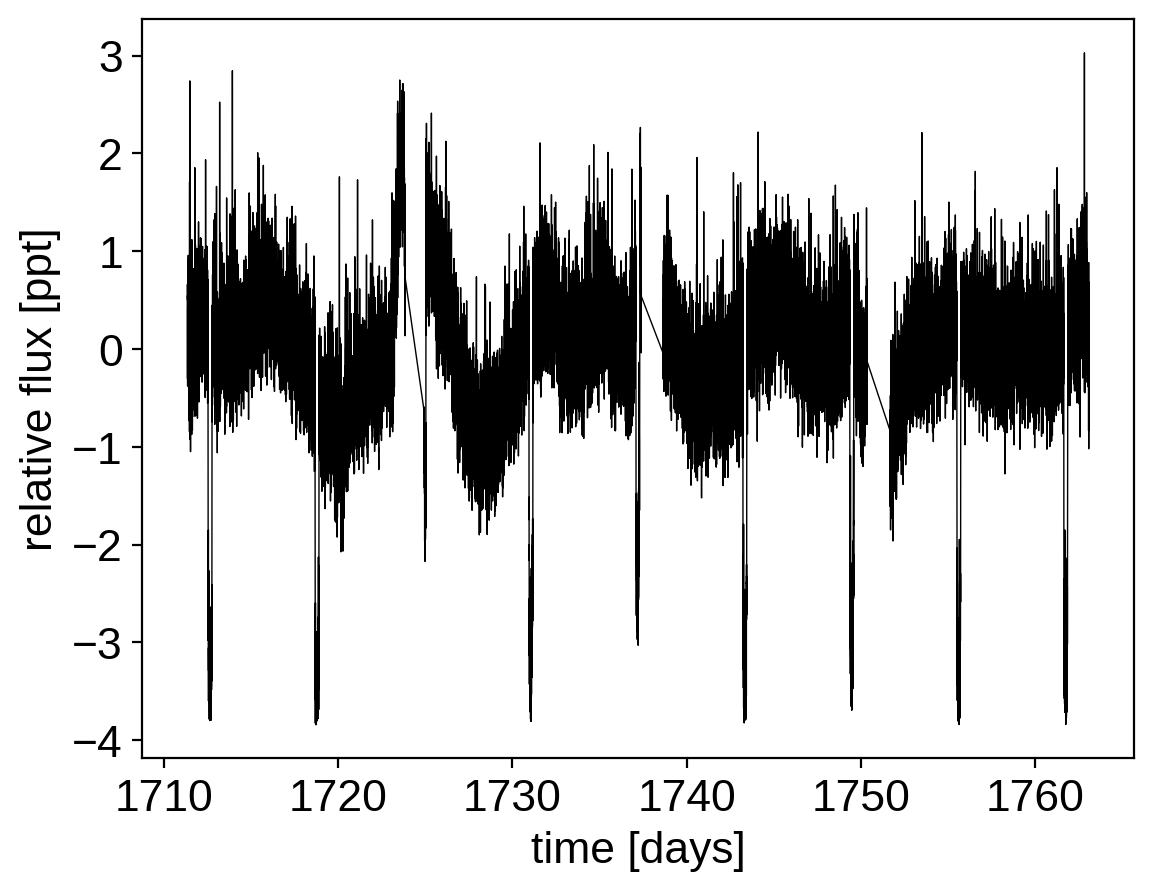

In [4]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

lcfs = lk.search_lightcurvefile("TIC 286923464", mission="TESS").download_all()
lc = lcfs.PDCSAP_FLUX.stitch()
lc = lc.remove_nans().remove_outliers()

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (lc.flux - 1), dtype=np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

texp = np.min(np.diff(x))

plt.plot(x, y, "k", linewidth=0.5)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]");

Then, find the period, phase and depth of the transit using box least squares:

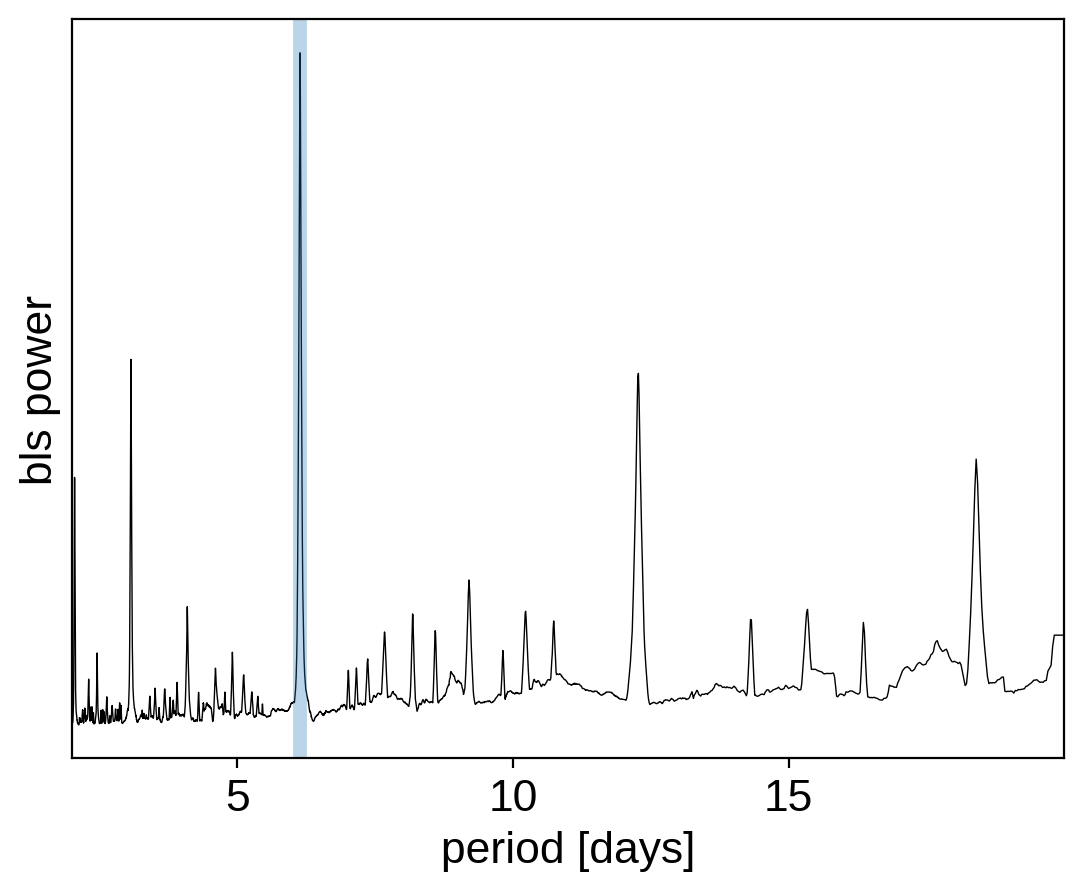

In [5]:
import exoplanet as xo

pg = xo.estimators.bls_estimator(x, y, yerr, min_period=2, max_period=20)

peak = pg["peak_info"]
period_guess = peak["period"]
t0_guess = peak["transit_time"]
depth_guess = peak["depth"]

plt.plot(pg["bls"].period, pg["bls"].power, "k", linewidth=0.5)
plt.axvline(period_guess, alpha=0.3, linewidth=5)
plt.xlabel("period [days]")
plt.ylabel("bls power")
plt.yticks([])
plt.xlim(pg["bls"].period.min(), pg["bls"].period.max());

Then, for efficiency purposes, let's extract just the data within 0.25 days of the transits:

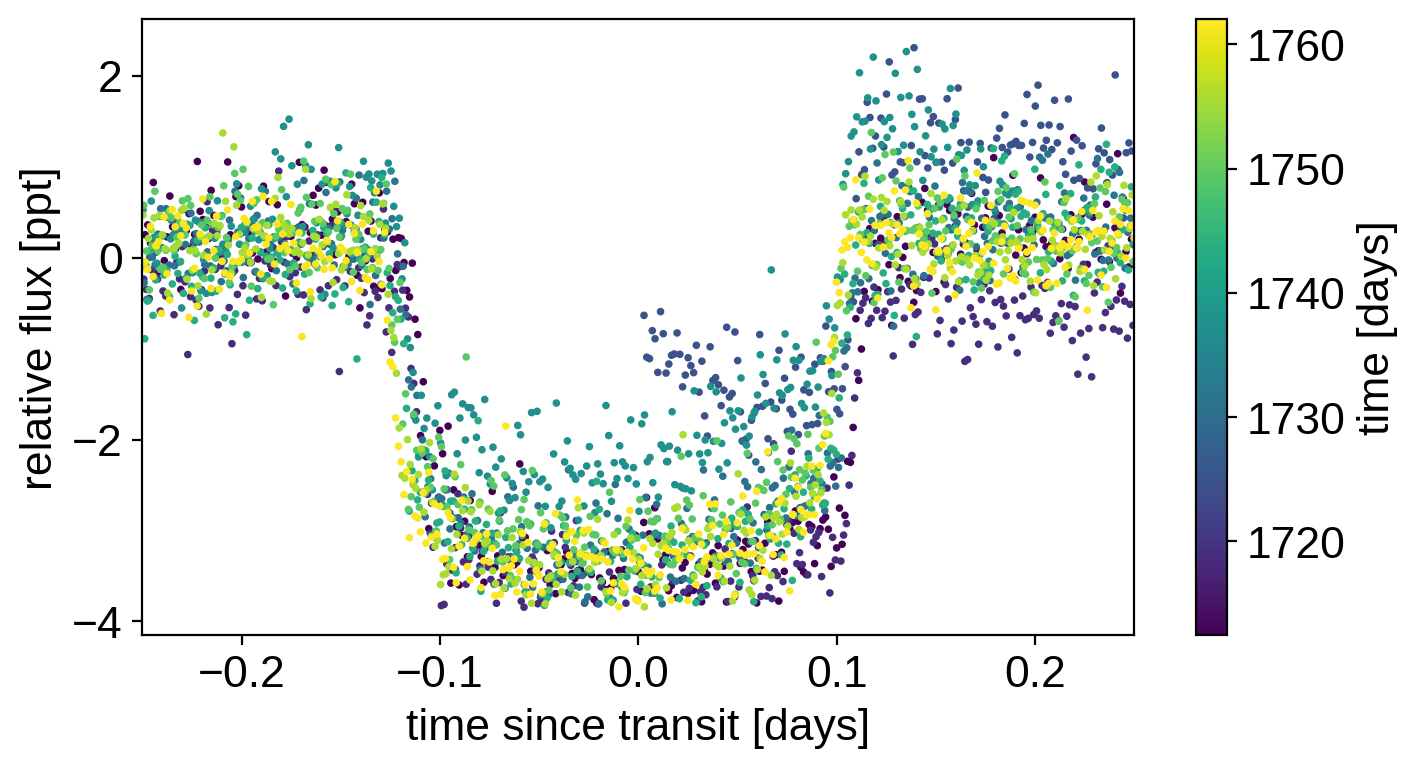

In [6]:
transit_mask = (
    np.abs((x - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess)
    < 0.25
)
x = np.ascontiguousarray(x[transit_mask])
y = np.ascontiguousarray(y[transit_mask])
yerr = np.ascontiguousarray(yerr[transit_mask])

plt.figure(figsize=(8, 4))
x_fold = (x - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess
plt.scatter(x_fold, y, c=x, s=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
plt.xlim(-0.25, 0.25);

That looks a little janky, but it's good enough for now.

## The probabilistic model

Here's how we set up the PyMC3 model in this case:

In [7]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Stellar parameters
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)
    u = xo.distributions.QuadLimbDark("u")
    log_r_star = pm.Normal(
        "log_r_star", mu=np.log(tic_r_star[0]), sigma=tic_r_star[1] / tic_r_star[0]
    )
    r_star = pm.Deterministic("r_star", tt.exp(log_r_star))
    star_params = [mean, u, log_r_star]

    # Gaussian process noise model
    sigma = pm.InverseGamma("sigma", alpha=3.0, beta=2 * np.median(yerr))
    log_Sw4 = pm.Normal("log_Sw4", mu=0.0, sigma=10.0)
    log_w0 = pm.Normal("log_w0", mu=np.log(2 * np.pi / 10.0), sigma=10.0)
    kernel = xo.gp.terms.SHOTerm(log_Sw4=log_Sw4, log_w0=log_w0, Q=1.0 / 3)
    noise_params = [sigma, log_Sw4, log_w0]

    # Planet parameters
    ror_guess = np.sqrt(depth_guess * 1e-3)
    log_r = pm.Normal("log_r", mu=np.log(ror_guess * tic_r_star[0]), sigma=10.0)
    r = pm.Deterministic("r", tt.exp(log_r))
    ror = pm.Deterministic("ror", tt.exp(log_r - log_r_star))

    # Orbital parameters
    log_period = pm.Normal("log_period", mu=np.log(period_guess), sigma=1.0)
    t0 = pm.Normal("t0", mu=t0_guess, sigma=1.0)
    log_dur = pm.Normal("log_dur", mu=np.log(0.1), sigma=10.0)
    b = xo.distributions.ImpactParameter("b", ror=ror)

    period = pm.Deterministic("period", tt.exp(log_period))
    dur = pm.Deterministic("dur", tt.exp(log_dur))

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=period, duration=dur, t0=t0, b=b, r_star=r_star
    )

    # We're going to track the implied density for reasons that will become clear later
    pm.Deterministic("rho_circ", orbit.rho_star)

    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(u)

    class LCModel:
        def __call__(self, t):
            return mean + 1e3 * tt.sum(
                star.get_light_curve(orbit=orbit, r=r, t=t), axis=-1
            )

    # Finally the GP observation model
    lc_model = LCModel()
    gp = xo.gp.GP(kernel, x, yerr ** 2 + sigma ** 2, mean=lc_model)
    gp.marginal("obs", observed=y)

    # Double check that everything looks good - we shouldn't see any NaNs!
    print(model.check_test_point())

    # Optimize the model
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [sigma])
    map_soln = xo.optimize(map_soln, noise_params)
    map_soln = xo.optimize(map_soln, star_params)
    map_soln = xo.optimize(map_soln, [log_r, b, log_dur])
    map_soln = xo.optimize(map_soln)

mean                   -3.22
u_quadlimbdark__       -2.77
log_r_star              1.99
sigma_log__            -0.53
log_Sw4                -3.22
log_w0                 -3.22
log_r                  -3.22
log_period             -0.92
t0                     -0.92
log_dur                -3.22
b_impact__             -1.39
obs                -19675.38
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [sigma]
15it [00:02,  6.99it/s, logp=-4.953335e+03] 
message: Optimization terminated successfully.
logp: -19696.025059913656 -> -4953.3352003882965
optimizing logp for variables: [log_w0, log_Sw4, sigma]
29it [00:00, 151.99it/s, logp=-1.663727e+03]
message: Optimization terminated successfully.
logp: -4953.3352003882965 -> -1663.7269287654838
optimizing logp for variables: [log_r_star, u, mean]
16it [00:00, 113.01it/s, logp=-1.605064e+03]
message: Optimization terminated successfully.
logp: -1663.7269287654854 -> -1605.0637108601081
optimizing logp for variables: [log_dur, b, log_r, log_r_star]
30it [00:00, 154.95it/s, logp=-1.564582e+03]
message: Optimization terminated successfully.
logp: -1605.0637108601081 -> -1564.5822034669525
optimizing logp for variables: [b, log_dur, t0, log_period, log_r, log_w0, log_Sw4, sigma, log_r_star, u, mean]
170it [00:00, 231.44it/s, logp=-1.155541e+03]
message: Desired error not necessarily achieved due to precision lo

Now we can plot our initial model:

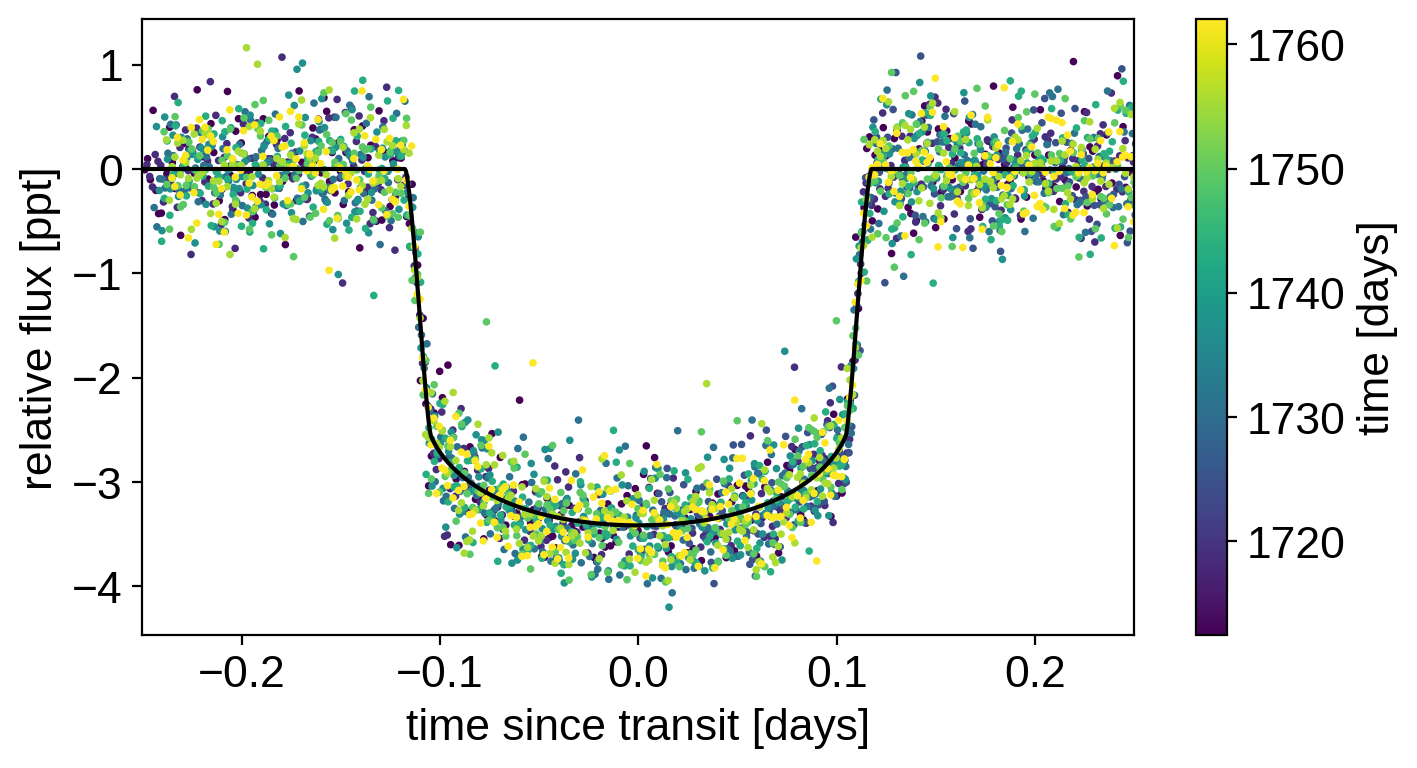

In [8]:
with model:
    gp_pred, lc_pred = xo.eval_in_model([gp.predict(), lc_model(x)], map_soln)

plt.figure(figsize=(8, 4))
x_fold = (x - map_soln["t0"] + 0.5 * map_soln["period"]) % map_soln[
    "period"
] - 0.5 * map_soln["period"]
inds = np.argsort(x_fold)
plt.scatter(x_fold, y - gp_pred - map_soln["mean"], c=x, s=3)
plt.plot(x_fold[inds], lc_pred[inds] - map_soln["mean"], "k")
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
plt.xlim(-0.25, 0.25);

That looks better!

Now on to sampling:

In [9]:
np.random.seed(721)
with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, log_dur, t0, log_period, log_r, log_w0, log_Sw4, sigma, log_r_star, u, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [02:27<00:00, 108.60draws/s]


Then we can take a look at the summary statistics:

In [10]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,0.275,0.155,-0.017,0.572,0.002,0.001,7987.0,6511.0,8138.0,5230.0,1.0
log_r_star,0.719,0.055,0.614,0.820,0.001,0.000,10213.0,10075.0,10217.0,5553.0,1.0
log_Sw4,6.423,0.373,5.729,7.131,0.004,0.003,9148.0,9058.0,9210.0,5305.0,1.0
log_w0,2.148,0.205,1.751,2.513,0.002,0.002,7498.0,7498.0,7568.0,5300.0,1.0
log_r,-2.182,0.056,-2.289,-2.078,0.001,0.000,10355.0,10355.0,10350.0,5932.0,1.0
log_period,1.814,0.000,1.814,1.814,0.000,0.000,10509.0,10509.0,10521.0,5471.0,1.0
t0,1737.202,0.000,1737.202,1737.202,0.000,0.000,10727.0,10727.0,10762.0,5347.0,1.0
log_dur,-1.504,0.002,-1.508,-1.500,0.000,0.000,9341.0,9341.0,9326.0,5416.0,1.0
u[0],0.290,0.091,0.125,0.465,0.001,0.001,6727.0,6727.0,6667.0,3022.0,1.0
u[1],0.118,0.122,-0.109,0.345,0.001,0.001,7004.0,3674.0,6963.0,3750.0,1.0


And plot the posterior covariances compared to the values from [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150):

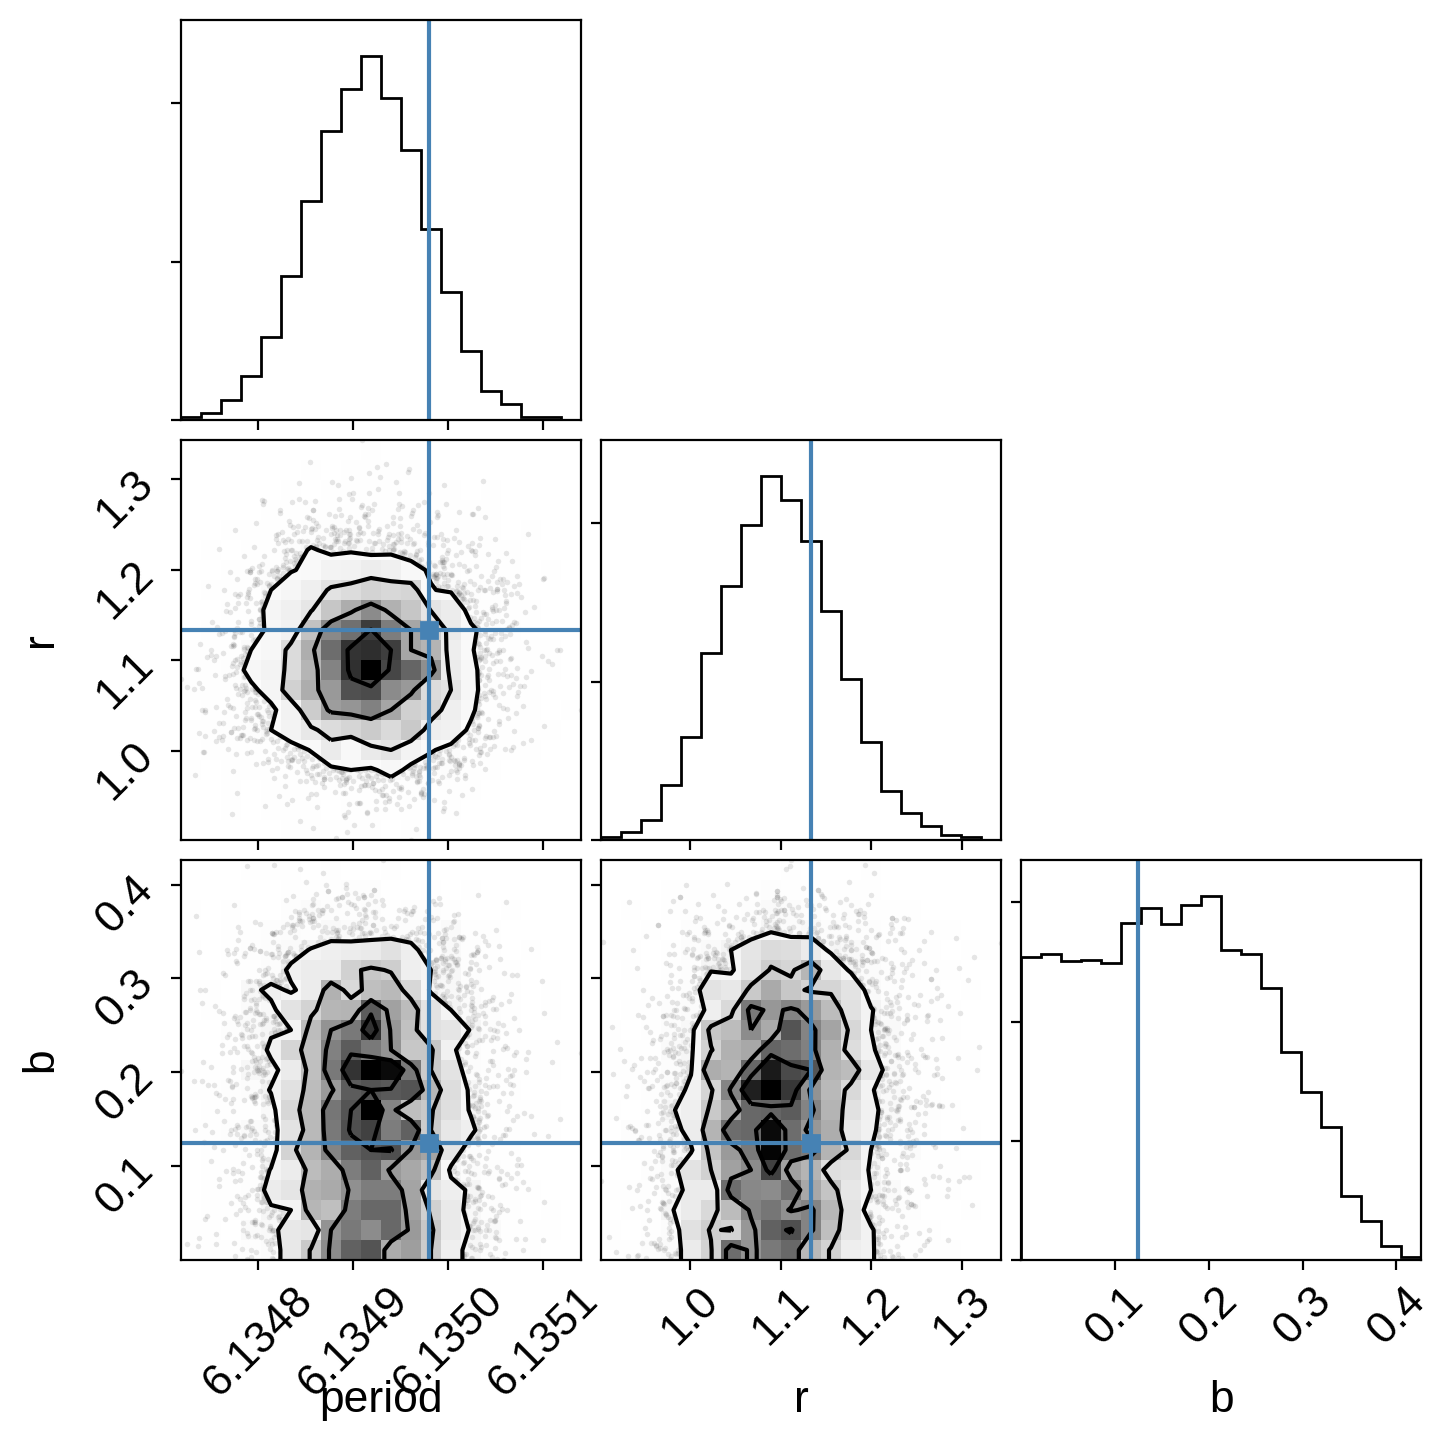

In [11]:
import corner
import astropy.units as u

samples = pm.trace_to_dataframe(trace, varnames=["period", "r", "b"])
samples.r = (samples.r.values * u.R_sun).to(u.R_jupiter).value

corner.corner(samples, truths=[6.134980, 1.133, 0.125]);

## Bonus: eccentricity

As discussed above, we fit this model assuming a circular orbit which speeds things up for a few reasons.
First, setting eccentricity to zero means that the orbital dynamics are much simpler and more computationally efficient, since we don't need to solve Kepler's equation numerically.
But this isn't actually the main effect!
Instead the bigger issues come from the fact that the degeneracies between eccentricity, arrgument of periasteron, impact parameter, and planet radius are hard for the sampler to handle, causing the sampler's performance to plummet.
In this case, by fitting with a circular orbit where duration is one of the parameters, everything is well behaved and the sampler runs faster.

But, in this case, the planet *is* actually on an eccentric orbit, so that assumption isn't justified.
It has been recognized by various researchers over the years (I first learned about this from [Bekki Dawson](https://arxiv.org/abs/1203.5537)) that, to first order, the eccentricity mainly just changes the transit duration.
The key realization is that this can be thought of as a change in the impled density of the star.
Therefore, if you fit the transit using stellar density (or duration, in this case) as one of the parameters (*note: you must have a* different *stellar density parameter for each planet if there are more than one*), you can use an independent measurement of the stellar density to infer the eccentricity of the orbit after the fact.
All the details are described in [Dawson & Johnson (2012)](https://arxiv.org/abs/1203.5537), but here's how you can do this here using the stellar density listed in the TESS input catalog:

eccentricity = 0.46 +0.25 -0.13


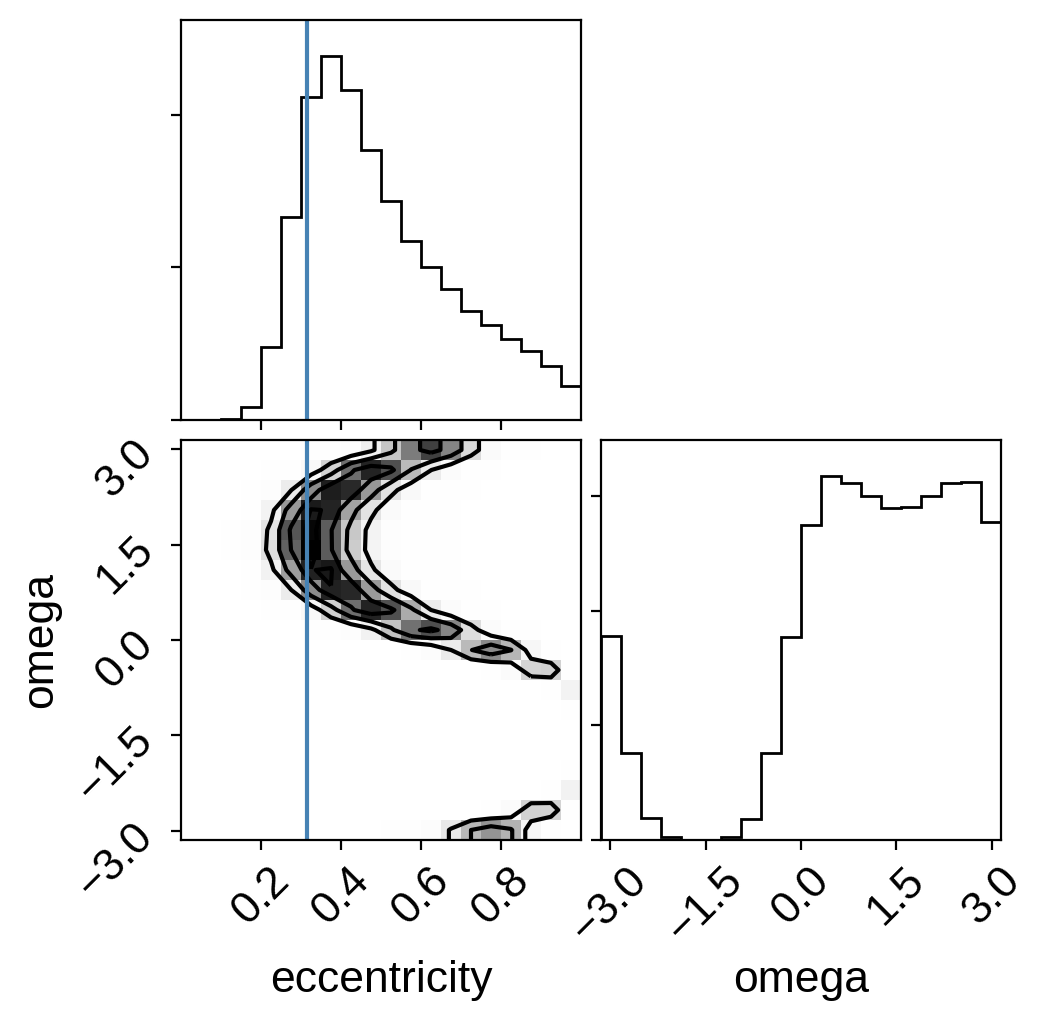

In [12]:
# Extract the implied density from the fit
rho_circ = np.repeat(trace["rho_circ"], 100)

# Sample eccentricity and omega from their priors (the math might
# be a little more subtle for more informative priors, but I leave
# that as an exercise for the reader...)
ecc = np.random.uniform(0, 1, len(rho_circ))
omega = np.random.uniform(-np.pi, np.pi, len(rho_circ))

# Compute the "g" parameter from Dawson & Johnson and what true
# density that implies
g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc ** 2)
rho = rho_circ / g ** 3

# Re-weight these samples to get weighted posterior samples
log_weights = -0.5 * ((rho - tic_rho_star[0]) / tic_rho_star[1]) ** 2
weights = np.exp(log_weights - np.max(log_weights))

# Estimate the expected posterior quantiles
q = corner.quantile(ecc, [0.16, 0.5, 0.84], weights=weights)
print("eccentricity = {0:.2f} +{1[1]:.2f} -{1[0]:.2f}".format(q[1], np.diff(q)))

corner.corner(
    np.vstack((ecc, omega)).T,
    weights=weights,
    truths=[0.316, None],
    plot_datapoints=False,
    labels=["eccentricity", "omega"],
);

As you can see, this eccentricity estimate is consistent (albeit with large uncertainties) with the value that [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150) measure using radial velocities and it is definitely clear that this planet is not on a circular orbit.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [13]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [14]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.2.5},
   month = mar,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
